In [6]:
import tribo as tb
import numpy as np
import os 
import re
import pandas as pd
from scipy.signal import savgol_filter as sgf # made by Albert

def split_string(s):
    return re.split('[-_]', s)

class Tribo_file:
	def __init__(self,file_folder, file_name):
		self.file_name = file_name
		self.file_folder = file_folder
		self.percent,self.name,self.force,self.speed,self.test = split_string(self.file_name)
		
		self.load_data()

	def load_data(self):
		self.data,self.xpos,self.Fx,self.Fz = tb.get_data(self.file_folder+"\\"+self.file_name,"all")
		

	def process_data(self,cutoff=0.1):

		self.xpos_peaks, self.xpos_valleys = tb.find_x_segments(self.xpos)

		segments=tb.segment_data(self.xpos, self.xpos_peaks, self.xpos_valleys,self.Fx,self.Fz)

		self.upward_sections, self.forward_friction, self.downward_sections, self.backward_friction=segments

		self.CoF_array = tb.calculate_CoF(self.upward_sections, self.forward_friction, self.downward_sections, self.backward_friction,cutoff)

		self.CoF_avg=np.average(self.CoF_array)
		self.CoF_std=np.std(self.CoF_array)

		pad_length = 3000 - len(self.CoF_array)
		if pad_length > 0:
			padded_array = np.pad(file_n.CoF_array, (0, pad_length), 'constant', constant_values=self.CoF_avg)
		else:
			padded_array = file_n.CoF_array

		self.CoF_array=padded_array




		

folder = 'DATA'

files_in_folder = os.listdir(folder)
print(f" Found {len(files_in_folder)} files in {folder}")

Tribo_files = []
complete_CoF_df = pd.DataFrame()
sg_smoothing = pd.DataFrame()

for file_name in files_in_folder:
	file_n=Tribo_file(folder, file_name)
	file_n.process_data(0.2)
	Tribo_files.append(file_n)
	# print(f"Processed {file_name} with CoF {file_n.CoF_array.shape} and % {file_n.percent} ")
	complete_CoF_df[file_name]=file_n.CoF_array

for column in complete_CoF_df.columns: # added by Albert
	sg_smoothing[column]=sgf(complete_CoF_df[column], 100, 2) # added by Albert

speeds=[]
names=[]

for file in Tribo_files:
	if file.speed not in speeds:
		speeds.append(file.speed)

	if file.name not in names:
		names.append(file.name)

# print(f" Procesing {speeds}")

speed_sheets=[]

# for speed in speeds:
# 	files_with_speed = [file for file in Tribo_files if file.speed == speed]

	
# 	rows=[]
# 	ii=0
# 	for file in files_with_speed:
# 		data_to_append = [ file.name,  file.CoF_avg,  file.CoF_std,file.percent,file.force,file.test]
# 		rows.append(data_to_append)

# 	df = pd.DataFrame(rows,columns=['Name','CoF_avg','CoF_std','Percent','Force','Test'])


# 	speed_sheets.append(df)

rows=[]
for file in Tribo_files:
	data_to_append = [ file.name,  file.CoF_avg,  file.CoF_std,file.speed, file.percent, file.force,file.test]
	rows.append(data_to_append)
	

df = pd.DataFrame(rows,columns=['Name','CoF_avg','CoF_std','Speed','Percent','Force','Test'])

print("This is the complete df\n",df)
for speed in speeds:
	speed_sheet=df[df['Speed']==speed]
	print("speed sheet\n",speed_sheet)
	speed_sheets.append(speed_sheet)

rows_total=[]
total_dfs=[]
with pd.ExcelWriter('output.xlsx') as writer: 
	for df,speed  in zip(speed_sheets,speeds): 
		rows_total=[]

		for name in df['Name'].unique():
			for force in df['Force'].unique():
				print(f"----------{name}\t{force}------------")
				df2=df[(df['Name']==name) & (df['Force']==force)]
				if df2.empty:
					continue
				CoF_total_avg=np.average(df2['CoF_avg'])
				CoF_total_std=np.average(df2['CoF_std'])
				print(df2.get("Force").iloc[0],df2.get("Percent").iloc[0])
				row=[name,CoF_total_avg,CoF_total_std,speed,df2.get("Force").iloc[0],df2.get("Percent").iloc[0]]
				
			
				print(row)
				rows_total.append(row)
		df=pd.DataFrame(rows_total,columns=['Name','CoF_avg','CoF_std','Speed', 'Force','Percent'])
		total_dfs.append(df)
		df.to_excel(writer, sheet_name=speed, index=False)
	
	complete_df=pd.concat(total_dfs)
	complete_df.to_excel(writer, sheet_name='Total', index=False)
	complete_CoF_df.to_excel(writer, sheet_name='CoF', index=True)
	sg_smoothing.to_excel(writer, sheet_name='Smoothed CoF', index=True) # added by Albert
	
		



 Found 24 files in DATA
This is the complete df
     Name   CoF_avg   CoF_std   Speed Percent Force    Test
0    OA0  0.149389  0.017284  100mms       0   10N  test12
1    OA0  0.129268  0.020919  100mms       0   10N   test3
2    OA0  0.110910  0.016482  100mms       0   10N   test8
3    OA0  0.157980  0.018407   20mms       0   10N  test14
4    OA0  0.178555  0.020883   20mms       0   10N   test4
5    OA0  0.150612  0.018965   20mms       0   10N   test6
6    OA0  0.146705  0.007325  100mms       0   20N  test13
7    OA0  0.131942  0.009320  100mms       0   20N   test2
8    OA0  0.144244  0.009370  100mms       0   20N   test7
9    OA0  0.158089  0.009677   20mms       0   20N   test1
10   OA0  0.170787  0.010615   20mms       0   20N  test11
11   OA0  0.150995  0.011565   20mms       0   20N   test5
12  ZADP  0.112659  0.006922  100mms       1   20N   Test5
13  ZADP  0.111450  0.008739  100mms       1   20N   Test6
14  ZADP  0.122727  0.006190  100mms       1   20N   Test7
15  ZAD

In [7]:
import sys

print(sys.path)

['c:\\Program Files\\Python311\\python311.zip', 'c:\\Program Files\\Python311\\DLLs', 'c:\\Program Files\\Python311\\Lib', 'c:\\Program Files\\Python311', '', 'C:\\Users\\alber\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\alber\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\alber\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\alber\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Program Files\\Python311\\Lib\\site-packages']


In [5]:
! pip install scipy

Defaulting to user installation because normal site-packages is not writeable


In [13]:
(df.get("Force").iloc[0])

'20N'

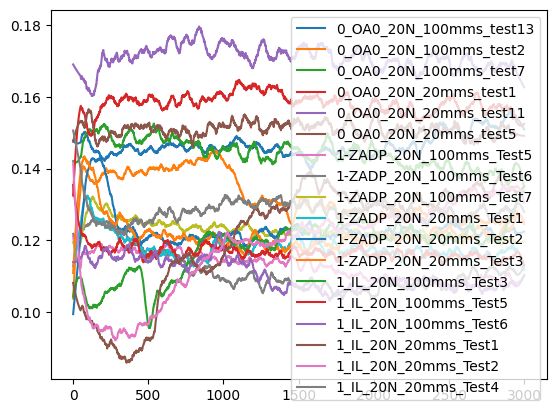

In [3]:
import matplotlib.pyplot as plt

for column in sg_smoothing.columns:
    if '20N' in column:
        plt.plot(sg_smoothing[column],label=column)
        plt.legend()



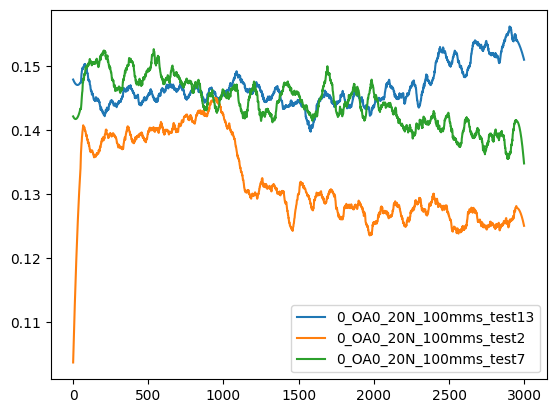

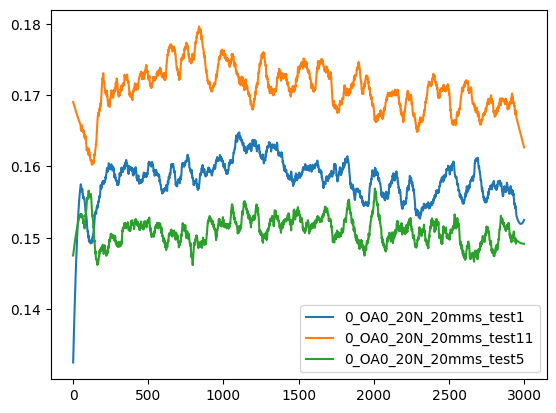

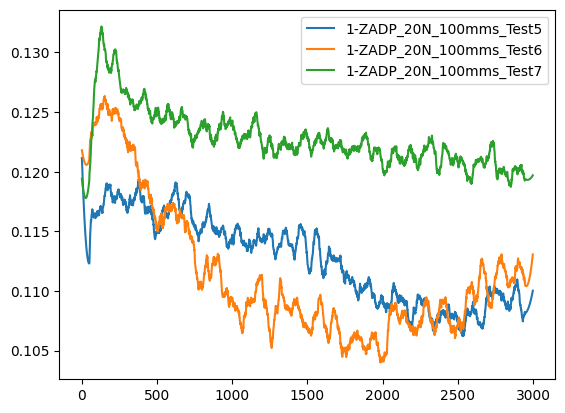

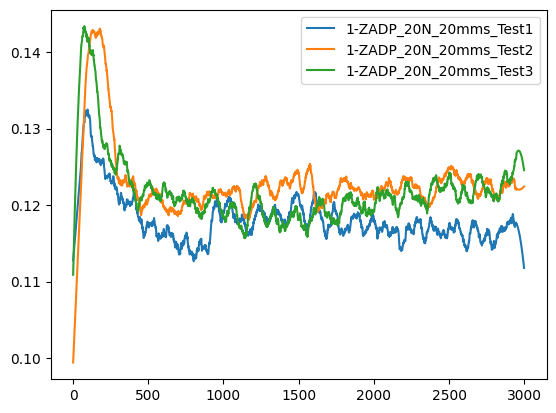

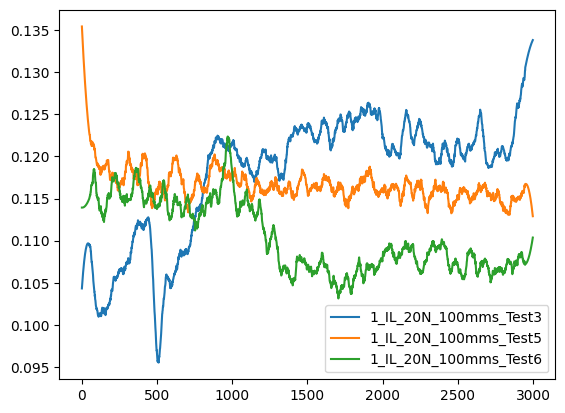

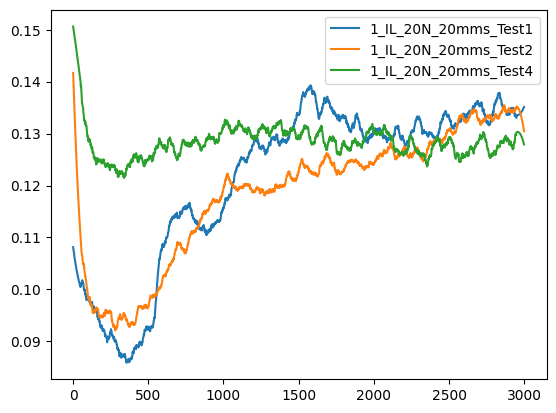

In [4]:
pattern = r'(_test|_Test).*'
unique_names = {}

for column in sg_smoothing.columns:
    if '20N' in column:
        # Apply the regex pattern to get the unique name
        unique_name = re.sub(pattern, '', column)
        # Check if the unique name is already a key in the dictionary
        if unique_name in unique_names:
            # Append the original column name to the list associated with the unique name
            unique_names[unique_name].append(column)
        else:
                # Create a new entry with the unique name as the key and a list containing the original column name
                unique_names[unique_name] = [column]

for (key, value) in unique_names.items():
    for spec_val in value:
        plt.plot(sg_smoothing[spec_val],label=spec_val)
    # plt.title(key)
    plt.legend()
    plt.show()
    # print(key, unique_names[key])

# for column in sg_smoothing.columns:
#     if '20N' in column:
#         if re.sub(pattern, '', column) in unique_names:
            
#             plt.plot(sg_smoothing[column],label=column)
#             plt.legend()